# Notebook to make `gif` version of Figure 4

In [ ]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')
cp3 = sns.color_palette('dark')

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_total_masses/'

### Setup

Load data

In [1]:
# Load in posteriors
posteriors_dict = h5ify.load(data_dir+'posteriors_different_total_masses.h5'),

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in the signals' parameters
injected_params_dict = h5ify.load(data_dir+'parameters_different_total_masses.h5')

# Load in the signals' strain
diff_mass_injs = h5ify.load(data_dir+'waveforms_different_total_masses.h5')

Set up plotting aesthetics

In [2]:
# Which total masses to plot
masses = [80, 100, 120, 140, 170, 220, 270, 320, 500]
masses_to_plot = [f'total mass {Mtot}' for Mtot in masses]

# Associated colors and labels
colors = [cp3[6], cp2[6],  cp2[4], 'mediumpurple', cp[4], cp3[4], cp3[0], cp[0], cp2[0]]
labels = [fr'$M = {Mtot} \, M_\odot$' for Mtot in masses]

# Get the prior samples for chi_p
chip_prior = np.asarray(prior_dict['chi_p'])

# For text on figures 
bbox_dict=dict(facecolor='white', edgecolor='silver', boxstyle='round')

# For posterior/prior histograms
chip_ymax = 3.5
hist_bins = np.linspace(pf.xlims['chi_p'][0],  pf.xlims['chi_p'][-1], 30)
prior_hist_kws = dict(histtype='step', density=True, bins=hist_bins, lw=1.5, color='gray', ls=':', zorder=0)

### Make animation

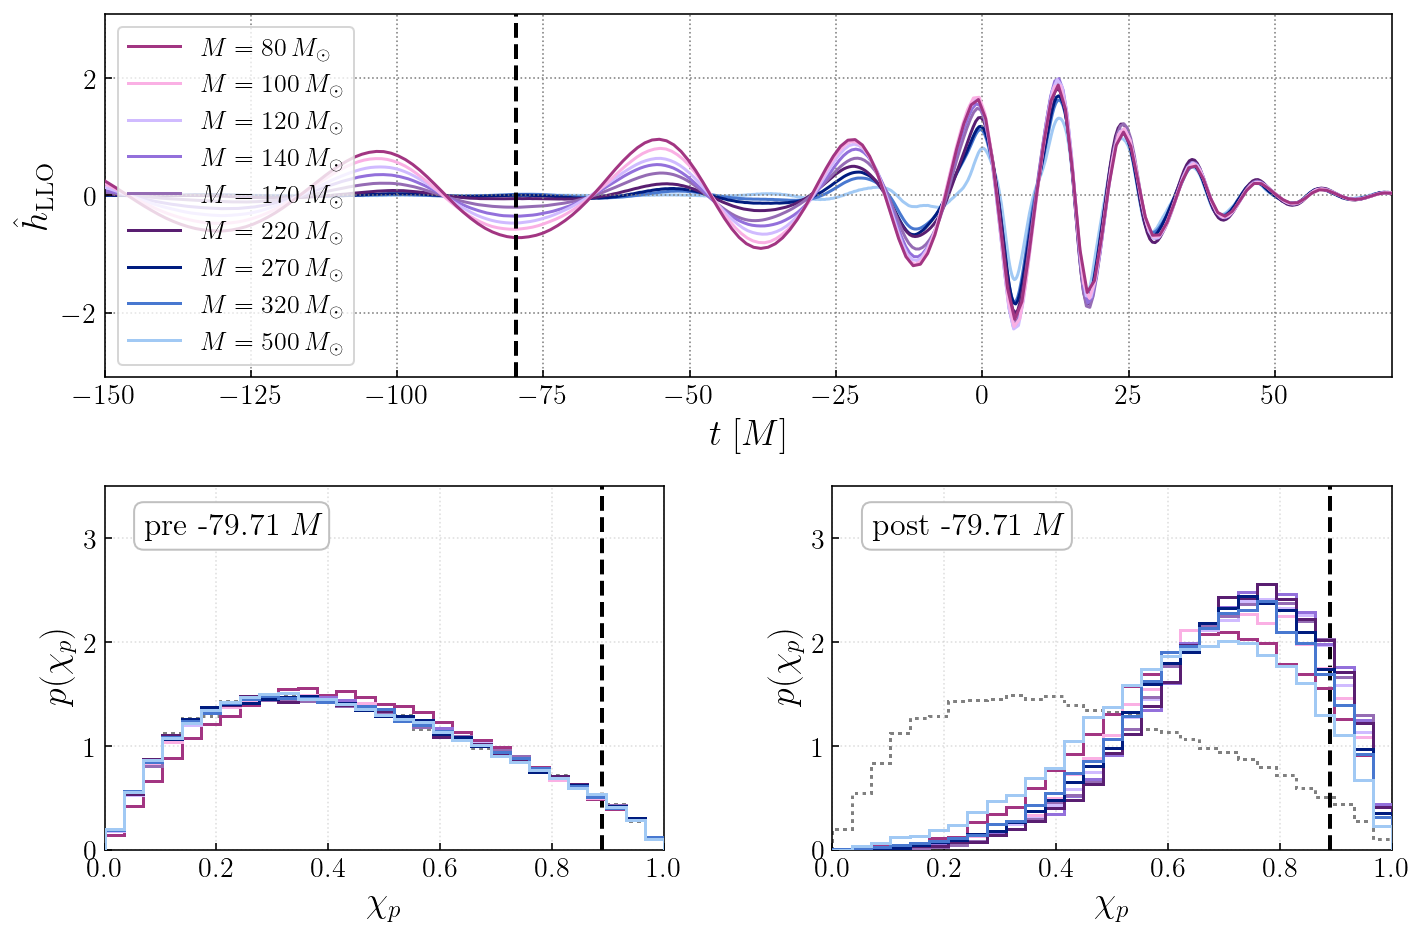

In [3]:
frames = []

for n, cycle in enumerate(pf.cutoff_cycles_all[:-2]):
    
    fig = plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH, pf.DEFAULT_FIG_WIDTH/1.5))
    axes1, axes2 = pf.custom_axes(2, [1, 2])

    # TOP ROW: waveforms with cutoff times
    ax = axes1[0]

    i=5
    for m,c,l in zip(masses_to_plot,colors,labels): 

        # injected
        times_s = np.asarray(diff_mass_injs[m]['time_dict']['L1']) - injected_params_dict[m]['L1_time']
        injected_wf = diff_mass_injs[m]['strain_wh']['L1']

        # transform times
        mass = int(m[-3:])
        times_M = pf.transform_s_to_M(times_s, mass)

        # plot
        ax.plot(times_M, injected_wf, color=c, label=l, zorder=i)
        i = i - 1

        #  vertical lines at the cutoff time 
        if '270' in m:

            t = pf.cycles_to_times_dict[m][cycle]
            tc_M = pf.transform_s_to_M(float(t), mass) # transform seconds -> M

            ax.axvline(tc_M, color='k', ls='--', lw=2, zorder=6)

    ax.set_xlim(-150,70)
    ax.set_ylim(-3.1,3.1)
    ax.set_xlabel(r'$t$~[$M$]')
    ax.set_ylabel(r'$\hat h_{\rm LLO}$')
    ax.legend(loc='upper left', fontsize=13, frameon=True)


    ## BOTTOM ROW: PRE- AND POST-CUTOFF POSTERIORS

    for color, mtotal in zip(colors, masses_to_plot): 

        # plot chi-p posteriors
        for prepost, ax in zip(['pre', 'post'], axes2): 

            t = pf.cycles_to_times_dict[mtotal][cycle]
            chip_posterior = posteriors_dict[0][mtotal][f'{prepost}_{t}']['chi_precessing']

            hist_kws = dict(histtype='step', density=True, bins=hist_bins, lw=1.5, color=color)

            p = 'chi_p'
            pf.plot_posterior(ax, chip_posterior, pf.xlims[p], chip_ymax, pf.params[p], **hist_kws, zorder=5-n)
            pf.plot_posterior(ax, chip_prior, pf.xlims[p], chip_ymax, pf.params[p], **prior_hist_kws)

            if '270' in mtotal:

                # plot true value
                ax.axvline(injected_params_dict[mtotal][p], color='k', lw=2, ls='--')

                # label
                t_M = pf.transform_s_to_M(float(t), float(injected_params_dict[mtotal]['mtotal']))
                t_M = np.round(t_M, 2)
                ax.text(0.07, 0.93, fr'{prepost} {t_M} $M$', fontsize=16, bbox=bbox_dict,
                             transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')

                ax.set_ylabel('Probability\ndensity')

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    
    # savename
    savename = f'for_gif_figure_04/frame{n:02}.png'
    plt.savefig(savename, dpi=300, bbox_inches='tight')
    
    if n==0: ## for checking that the plot looks good
        plt.show()
    else: 
        plt.close()
    
    # append to `frames` which will be used to make the gif
    image = imageio.v2.imread(savename)
    frames.append(image)

In [ ]:
# Assemble into a gif
fps = 1.5
imageio.mimsave('gif_figure_04.gif', frames, fps=fps) 